In [1]:
# Library Imports.
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle

# Allows plots to appear directly in the notebook.
%matplotlib inline

import pymysql
import os
#import mysql-connector-python

from flask import Flask, render_template, request,session,redirect,url_for
from sqlalchemy import create_engine

from patsy import dmatrices
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score 

### Create a connection to the database

In [2]:


con = pymysql.connect(
    host="localhost",
    user="root",
    password="1234",
    database="dbikes_main",
    charset="utf8mb4"
    
)

cur=con.cursor()

### Create two dataframes from the two sql queries

In [3]:
# DF stations contains the data for the stations and the useful variables
df_stations = pd.read_sql("Select Number,AvailableBikeStands,AvailableBikes,LastUpdate FROM dynamic_stations GROUP BY(Number) ,HOUR (LastUpdate), DAY(LastUpdate)",con)
# df_weather contains the data for the weather table
df_weather = pd.read_sql("Select Description,Temperature,Humidity,Visibility,LastUpdate From weather_data GROUP BY DAY(LastUpdate),HOUR(LastUpdate)",con)

### Explore the data

In [4]:
df_stations.shape

(38522, 4)

In [5]:
df_stations.head(10)

,Number,AvailableBikeStands,AvailableBikes,LastUpdate
0,42,15,15,2021-03-18 20:07:03
1,30,7,13,2021-03-18 20:04:17
2,54,14,19,2021-03-18 20:08:02
3,108,35,5,2021-03-18 20:12:48
4,56,23,16,2021-03-18 20:12:48
5,6,20,0,2021-03-18 20:04:11
6,18,18,12,2021-03-18 20:08:10
7,32,17,13,2021-03-18 20:09:20
8,52,25,7,2021-03-18 20:11:34
9,48,24,16,2021-03-18 20:11:25


In [6]:
df_stations.tail(10)

,Number,AvailableBikeStands,AvailableBikes,LastUpdate
38512,36,26,14,2021-04-02 13:06:43
38513,2,17,3,2021-04-02 13:10:29
38514,75,24,16,2021-04-02 13:11:14
38515,100,2,23,2021-04-02 13:06:50
38516,64,29,11,2021-04-02 13:07:58
38517,109,19,10,2021-04-02 13:07:26
38518,44,24,6,2021-04-02 13:10:47
38519,57,18,5,2021-04-02 13:08:57
38520,80,25,15,2021-04-02 13:07:53
38521,39,18,2,2021-04-02 13:11:12


In [7]:
df_weather.shape

(354, 5)

In [8]:
df_weather.head(10)

,Description,Temperature,Humidity,Visibility,LastUpdate
0,broken clouds,283.96,87,3.60,2021-03-18 20:14:24
1,broken clouds,283.67,93,4.12,2021-03-18 21:04:39
2,scattered clouds,282.9,87,5.66,2021-03-18 22:04:59
3,scattered clouds,282.46,93,7.72,2021-03-18 23:00:44
4,scattered clouds,282.43,87,6.17,2021-03-19 00:01:05
5,scattered clouds,282.13,93,5.14,2021-03-19 01:01:27
6,broken clouds,281.93,87,5.14,2021-03-19 02:01:50
7,few clouds,281.23,87,3.60,2021-03-19 03:02:13
8,few clouds,279.79,93,3.60,2021-03-19 04:02:38
9,few clouds,279.74,93,3.09,2021-03-19 05:03:03


#### Get the datatypes

In [9]:
df_stations.dtypes

Number                          int64
AvailableBikeStands             int64
AvailableBikes                  int64
LastUpdate             datetime64[ns]
dtype: object

In [10]:
df_weather.dtypes

Description            object
Temperature            object
Humidity                int64
Visibility            float64
LastUpdate     datetime64[ns]
dtype: object

### Create a new column equal to the time rounded to the nearest Hour

In [11]:
df_stations["dayHour"]=df_stations["LastUpdate"].dt.round("H")

In [12]:
df_stations.head(20)

,Number,AvailableBikeStands,AvailableBikes,LastUpdate,dayHour
0,42,15,15,2021-03-18 20:07:03,2021-03-18 20:00:00
1,30,7,13,2021-03-18 20:04:17,2021-03-18 20:00:00
2,54,14,19,2021-03-18 20:08:02,2021-03-18 20:00:00
3,108,35,5,2021-03-18 20:12:48,2021-03-18 20:00:00
4,56,23,16,2021-03-18 20:12:48,2021-03-18 20:00:00
5,6,20,0,2021-03-18 20:04:11,2021-03-18 20:00:00
6,18,18,12,2021-03-18 20:08:10,2021-03-18 20:00:00
7,32,17,13,2021-03-18 20:09:20,2021-03-18 20:00:00
8,52,25,7,2021-03-18 20:11:34,2021-03-18 20:00:00
9,48,24,16,2021-03-18 20:11:25,2021-03-18 20:00:00


In [13]:
df_stations.dtypes

Number                          int64
AvailableBikeStands             int64
AvailableBikes                  int64
LastUpdate             datetime64[ns]
dayHour                datetime64[ns]
dtype: object

### Create a new column equal to the time rounded to the nearest Hour but for the weather

(to match the times)

In [14]:
df_weather["dayHour"]=df_weather["LastUpdate"].dt.round("H")

In [15]:
df_weather.head(10)

,Description,Temperature,Humidity,Visibility,LastUpdate,dayHour
0,broken clouds,283.96,87,3.60,2021-03-18 20:14:24,2021-03-18 20:00:00
1,broken clouds,283.67,93,4.12,2021-03-18 21:04:39,2021-03-18 21:00:00
2,scattered clouds,282.9,87,5.66,2021-03-18 22:04:59,2021-03-18 22:00:00
3,scattered clouds,282.46,93,7.72,2021-03-18 23:00:44,2021-03-18 23:00:00
4,scattered clouds,282.43,87,6.17,2021-03-19 00:01:05,2021-03-19 00:00:00
5,scattered clouds,282.13,93,5.14,2021-03-19 01:01:27,2021-03-19 01:00:00
6,broken clouds,281.93,87,5.14,2021-03-19 02:01:50,2021-03-19 02:00:00
7,few clouds,281.23,87,3.60,2021-03-19 03:02:13,2021-03-19 03:00:00
8,few clouds,279.79,93,3.60,2021-03-19 04:02:38,2021-03-19 04:00:00
9,few clouds,279.74,93,3.09,2021-03-19 05:03:03,2021-03-19 05:00:00


In [16]:
df_weather.dtypes

Description            object
Temperature            object
Humidity                int64
Visibility            float64
LastUpdate     datetime64[ns]
dayHour        datetime64[ns]
dtype: object

### Drop the duplicates

In [17]:
df_weather.drop_duplicates(keep=False)

,Description,Temperature,Humidity,Visibility,LastUpdate,dayHour
0,broken clouds,283.96,87,3.60,2021-03-18 20:14:24,2021-03-18 20:00:00
1,broken clouds,283.67,93,4.12,2021-03-18 21:04:39,2021-03-18 21:00:00
2,scattered clouds,282.9,87,5.66,2021-03-18 22:04:59,2021-03-18 22:00:00
3,scattered clouds,282.46,93,7.72,2021-03-18 23:00:44,2021-03-18 23:00:00
4,scattered clouds,282.43,87,6.17,2021-03-19 00:01:05,2021-03-19 00:00:00
...,...,...,...,...,...,...
349,broken clouds,279.71,81,6.17,2021-04-02 09:00:37,2021-04-02 09:00:00
350,broken clouds,279.76,75,6.69,2021-04-02 10:04:58,2021-04-02 10:00:00
351,broken clouds,280.25,70,5.66,2021-04-02 11:03:59,2021-04-02 11:00:00
352,broken clouds,280.84,71,6.17,2021-04-02 12:03:01,2021-04-02 12:00:00


In [18]:
df_weather.shape

(354, 6)

Turns out there are no duplicates, high five yourself for good database and scraper design

### Merge the two dataframes on the new dayHour column

In [19]:
train_data=pd.merge(df_stations,
                   df_weather,
                   on ="dayHour")

#### Explore the new dataframe

In [20]:
train_data.shape

(38522, 10)

In [21]:
train_data.head(10)

,Number,AvailableBikeStands,AvailableBikes,LastUpdate_x,dayHour,Description,Temperature,Humidity,Visibility,LastUpdate_y
0,42,15,15,2021-03-18 20:07:03,2021-03-18 20:00:00,broken clouds,283.96,87,3.6,2021-03-18 20:14:24
1,30,7,13,2021-03-18 20:04:17,2021-03-18 20:00:00,broken clouds,283.96,87,3.6,2021-03-18 20:14:24
2,54,14,19,2021-03-18 20:08:02,2021-03-18 20:00:00,broken clouds,283.96,87,3.6,2021-03-18 20:14:24
3,108,35,5,2021-03-18 20:12:48,2021-03-18 20:00:00,broken clouds,283.96,87,3.6,2021-03-18 20:14:24
4,56,23,16,2021-03-18 20:12:48,2021-03-18 20:00:00,broken clouds,283.96,87,3.6,2021-03-18 20:14:24
5,6,20,0,2021-03-18 20:04:11,2021-03-18 20:00:00,broken clouds,283.96,87,3.6,2021-03-18 20:14:24
6,18,18,12,2021-03-18 20:08:10,2021-03-18 20:00:00,broken clouds,283.96,87,3.6,2021-03-18 20:14:24
7,32,17,13,2021-03-18 20:09:20,2021-03-18 20:00:00,broken clouds,283.96,87,3.6,2021-03-18 20:14:24
8,52,25,7,2021-03-18 20:11:34,2021-03-18 20:00:00,broken clouds,283.96,87,3.6,2021-03-18 20:14:24
9,48,24,16,2021-03-18 20:11:25,2021-03-18 20:00:00,broken clouds,283.96,87,3.6,2021-03-18 20:14:24


Drop the (now) outdate date columns

In [22]:
train_data = train_data.drop(columns=["LastUpdate_x","LastUpdate_y"])

In [23]:
train_data.head(10)

,Number,AvailableBikeStands,AvailableBikes,dayHour,Description,Temperature,Humidity,Visibility
0,42,15,15,2021-03-18 20:00:00,broken clouds,283.96,87,3.6
1,30,7,13,2021-03-18 20:00:00,broken clouds,283.96,87,3.6
2,54,14,19,2021-03-18 20:00:00,broken clouds,283.96,87,3.6
3,108,35,5,2021-03-18 20:00:00,broken clouds,283.96,87,3.6
4,56,23,16,2021-03-18 20:00:00,broken clouds,283.96,87,3.6
5,6,20,0,2021-03-18 20:00:00,broken clouds,283.96,87,3.6
6,18,18,12,2021-03-18 20:00:00,broken clouds,283.96,87,3.6
7,32,17,13,2021-03-18 20:00:00,broken clouds,283.96,87,3.6
8,52,25,7,2021-03-18 20:00:00,broken clouds,283.96,87,3.6
9,48,24,16,2021-03-18 20:00:00,broken clouds,283.96,87,3.6


#### Get the value counts (and the unique values) for the weather description

In [24]:
print(train_data["Description"].value_counts())

broken clouds       21730
scattered clouds     6762
few clouds           4580
overcast clouds      1744
clear sky            1526
light rain           1418
moderate rain         544
mist                  218
Name: Description, dtype: int64


Create new columns (boolean) if cloudy or rainy

In [25]:
train_data["rain"]=train_data["Description"].str.contains("rain")
train_data["cloudy"]=train_data["Description"].str.contains("clouds")

In [26]:
train_data["cloudy"].value_counts()

True     34816
False     3706
Name: cloudy, dtype: int64

In [27]:
train_data["rain"].value_counts()

False    36560
True      1962
Name: rain, dtype: int64

In [28]:
train_data.head(10)

,Number,AvailableBikeStands,AvailableBikes,dayHour,Description,Temperature,Humidity,Visibility,rain,cloudy
0,42,15,15,2021-03-18 20:00:00,broken clouds,283.96,87,3.6,False,True
1,30,7,13,2021-03-18 20:00:00,broken clouds,283.96,87,3.6,False,True
2,54,14,19,2021-03-18 20:00:00,broken clouds,283.96,87,3.6,False,True
3,108,35,5,2021-03-18 20:00:00,broken clouds,283.96,87,3.6,False,True
4,56,23,16,2021-03-18 20:00:00,broken clouds,283.96,87,3.6,False,True
5,6,20,0,2021-03-18 20:00:00,broken clouds,283.96,87,3.6,False,True
6,18,18,12,2021-03-18 20:00:00,broken clouds,283.96,87,3.6,False,True
7,32,17,13,2021-03-18 20:00:00,broken clouds,283.96,87,3.6,False,True
8,52,25,7,2021-03-18 20:00:00,broken clouds,283.96,87,3.6,False,True
9,48,24,16,2021-03-18 20:00:00,broken clouds,283.96,87,3.6,False,True


In [29]:
train_data = train_data.drop(columns=["Description"])

In [30]:
train_data.head()

,Number,AvailableBikeStands,AvailableBikes,dayHour,Temperature,Humidity,Visibility,rain,cloudy
0,42,15,15,2021-03-18 20:00:00,283.96,87,3.6,False,True
1,30,7,13,2021-03-18 20:00:00,283.96,87,3.6,False,True
2,54,14,19,2021-03-18 20:00:00,283.96,87,3.6,False,True
3,108,35,5,2021-03-18 20:00:00,283.96,87,3.6,False,True
4,56,23,16,2021-03-18 20:00:00,283.96,87,3.6,False,True


Get the value counts of the temperature (to make sure the data is accurate)

In [31]:
train_data["Temperature"].value_counts()

281.24    981
281.51    436
281.08    436
281.18    328
280.77    327
         ... 
286.47    106
286.23    104
286.42    102
286.09    100
286.29     95
Name: Temperature, Length: 277, dtype: int64

In [32]:
train_data.dtypes

Number                          int64
AvailableBikeStands             int64
AvailableBikes                  int64
dayHour                datetime64[ns]
Temperature                    object
Humidity                        int64
Visibility                    float64
rain                             bool
cloudy                           bool
dtype: object

### Change temperature to celcius

In [33]:
train_data["Temperature"]=train_data["Temperature"].astype(float) -273.15

Create new column is weekday which is a boolean value indicating if the date is a saturday or sunday

In [34]:
train_data["isWeekDay"]=train_data["dayHour"].dt.weekday

In [35]:
train_data.dtypes

Number                          int64
AvailableBikeStands             int64
AvailableBikes                  int64
dayHour                datetime64[ns]
Temperature                   float64
Humidity                        int64
Visibility                    float64
rain                             bool
cloudy                           bool
isWeekDay                       int64
dtype: object

Sets true if is a saturday or sunday else false

In [36]:
train_data.replace({"isWeekDay":{6:True, 5:True, 4:False, 3:False, 2:False, 1:False, 0:False}},inplace=True)

In [37]:
train_data.head(5)

,Number,AvailableBikeStands,AvailableBikes,dayHour,Temperature,Humidity,Visibility,rain,cloudy,isWeekDay
0,42,15,15,2021-03-18 20:00:00,10.81,87,3.6,False,True,False
1,30,7,13,2021-03-18 20:00:00,10.81,87,3.6,False,True,False
2,54,14,19,2021-03-18 20:00:00,10.81,87,3.6,False,True,False
3,108,35,5,2021-03-18 20:00:00,10.81,87,3.6,False,True,False
4,56,23,16,2021-03-18 20:00:00,10.81,87,3.6,False,True,False


In [38]:
train_data["isWeekDay"].value_counts()

False    28064
True     10458
Name: isWeekDay, dtype: int64

In [39]:
train_data["Hour"]=train_data["dayHour"].dt.hour

In [40]:
train_data.head()

,Number,AvailableBikeStands,AvailableBikes,dayHour,Temperature,Humidity,Visibility,rain,cloudy,isWeekDay,Hour
0,42,15,15,2021-03-18 20:00:00,10.81,87,3.6,False,True,False,20
1,30,7,13,2021-03-18 20:00:00,10.81,87,3.6,False,True,False,20
2,54,14,19,2021-03-18 20:00:00,10.81,87,3.6,False,True,False,20
3,108,35,5,2021-03-18 20:00:00,10.81,87,3.6,False,True,False,20
4,56,23,16,2021-03-18 20:00:00,10.81,87,3.6,False,True,False,20


In [41]:
prediction_variables = ["Temperature","Humidity","Hour"]
prediction_variables_bool=["isWeekDay","rain"]

In [ ]:
p = train_data[["AvailableBikes","Temperature"]]
ax = p.plot.bar("Temperature","AvailableBikes")
ax

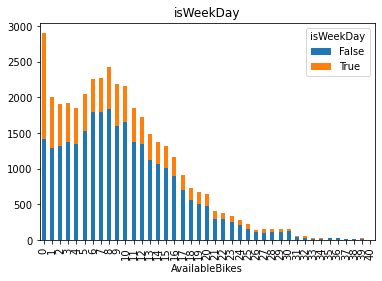

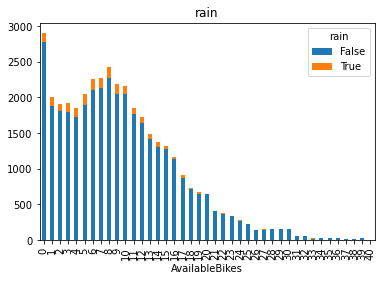

In [43]:
for i in prediction_variables_bool:
    p=train_data.groupby(["AvailableBikes",i]).size()
    p.unstack().plot(kind="bar",stacked=True)
    plt.title(i)
    plt.show()

# Create the Prediction model

Version 1: A single prediction model for the whole dataset

In [44]:
x=train_data[["Hour","Temperature","rain","isWeekDay"]]
y= train_data["AvailableBikes"]

In [45]:
X_train, X_test, y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=0)

In [46]:
regressor=LinearRegression()
regressor.fit(X_train,y_train)

LinearRegression()

In [47]:
coeff_df = pd.DataFrame(regressor.coef_,x.columns,columns=["Coefficient"])

In [48]:
coeff_df

,Coefficient
Hour,0.012533
Temperature,-0.183165
rain,-1.447963
isWeekDay,-1.281265


In [49]:
y_pred=regressor.predict(X_test)

dfer=pd.DataFrame({"Actual":y_test, "Predicted":y_pred})
dfer

,Actual,Predicted
25001,4,7.985064
26974,1,9.013174
16430,7,10.011713
8802,2,9.866435
31122,18,9.190176
...,...,...
33524,6,9.031400
17245,16,9.688864
5455,10,8.688040
31307,10,9.697255


In [50]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 5.474403663816058
Mean Squared Error: 47.49192480426049
Root Mean Squared Error: 6.891438514871949


Turns out running on the whole dataset isnt the best for an accurate prediction model and so the 

### Model 2, One for each station

Create a list of the unique station numbers

In [51]:
station_numbers=train_data["Number"].unique()

# This dictionary will be used to store the prediction models (the station number is the key) This will be pickled later on
regression_models={}

In [52]:
# For each station Create the model, Test it, Print the test results and then add the model to the dictionary
for i in station_numbers:
    df=train_data.loc[train_data["Number"] == i]
    #x=df[["Hour","Temperature","rain","isWeekDay"]]
    x=df[["Hour","Temperature","rain","isWeekDay"]]
    y= df["AvailableBikes"]
    X_train, X_test, y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=0)
    regressor=LinearRegression()
    regressor.fit(X_train,y_train)
    y_pred=regressor.predict(X_test)
    print(i,'Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
    print(i,'Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
    print(i,'Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    print("-------------------------------------------------------------------------------")
    regression_models[i]=regressor


42 Mean Absolute Error: 5.580889476015698
42 Mean Squared Error: 44.4994052801985
42 Root Mean Squared Error: 6.670787455780502
-------------------------------------------------------------------------------
30 Mean Absolute Error: 2.7163139075596185
30 Mean Squared Error: 11.694338619824848
30 Root Mean Squared Error: 3.419698615349728
-------------------------------------------------------------------------------
54 Mean Absolute Error: 3.1477830191076146
54 Mean Squared Error: 19.246079887778514
54 Root Mean Squared Error: 4.387035432701508
-------------------------------------------------------------------------------
108 Mean Absolute Error: 5.062862150444508
108 Mean Squared Error: 38.3686470516997
108 Root Mean Squared Error: 6.194243057202365
-------------------------------------------------------------------------------
56 Mean Absolute Error: 4.086784411392754
56 Mean Squared Error: 25.65927491867955
56 Root Mean Squared Error: 5.06549848669206
-------------------------------

8 Mean Absolute Error: 5.355742419685933
8 Mean Squared Error: 43.43513202328531
8 Root Mean Squared Error: 6.590533515830514
-------------------------------------------------------------------------------
27 Mean Absolute Error: 3.211796065001511
27 Mean Squared Error: 14.710918440293877
27 Root Mean Squared Error: 3.835481513486133
-------------------------------------------------------------------------------
16 Mean Absolute Error: 2.4448119453323254
16 Mean Squared Error: 8.493136675237903
16 Root Mean Squared Error: 2.914298659238257
-------------------------------------------------------------------------------
96 Mean Absolute Error: 3.5217244250653468
96 Mean Squared Error: 18.55539763924325
96 Root Mean Squared Error: 4.307597664504341
-------------------------------------------------------------------------------
82 Mean Absolute Error: 3.4744604780575847
82 Mean Squared Error: 17.53173855157197
82 Root Mean Squared Error: 4.187091896719245
----------------------------------

29 Mean Absolute Error: 5.983426018839933
29 Mean Squared Error: 57.41738708596751
29 Root Mean Squared Error: 7.577426151799007
-------------------------------------------------------------------------------
103 Mean Absolute Error: 2.1366658237395537
103 Mean Squared Error: 7.809625171549144
103 Root Mean Squared Error: 2.7945706596092976
-------------------------------------------------------------------------------
28 Mean Absolute Error: 4.555448515701313
28 Mean Squared Error: 33.09140686974485
28 Root Mean Squared Error: 5.752513091662187
-------------------------------------------------------------------------------
39 Mean Absolute Error: 2.919422764989316
39 Mean Squared Error: 13.66038088493734
39 Root Mean Squared Error: 3.695995249582626
-------------------------------------------------------------------------------
83 Mean Absolute Error: 6.346582011699526
83 Mean Squared Error: 57.79439321768621
83 Root Mean Squared Error: 7.6022623749569584
-----------------------------

Testing that the dictionary save method works

In [53]:
testy = train_data.iloc[[69]]
testy_data=testy[["Hour","Temperature","rain","isWeekDay"]]
regression= regression_models[testy.iloc[0]["Number"]]

print(testy_data)

regression.predict(testy_data)

    Hour  Temperature   rain  isWeekDay
69    20        10.81  False      False


array([5.77348977])

Create the pickle file

In [54]:
pickle_out = open("dict.pickle","wb")
pickle.dump(regression_models,pickle_out)
pickle_out.close()